이 자료는 위키독스 딥 러닝을 이용한 자연어 처리 입문의 영어/한국어 Word2Vec 실습 학습 자료입니다.  
링크 : https://wikidocs.net/50739

# 09-03 영어/한국어 Word2Vec 실습
---

파이썬의 gensim 패키지에는 Word2Vec을 지원하고 있어, gensim 패키지를 이용하면 손쉽게 단어를 임베딩 벡터로 변환시킬 수 있습니다. 영어로 된 코퍼스를 다운받아 전처리를 수행하고, 전처리한 데이터를 바탕으로 Word2Vec 작업을 진행하겠습니다.

In [1]:
import gensim
gensim.__version__

'4.3.3'

In [2]:
pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 26.3 MB/s eta 0:00:00


---
## 1. 영어 Word2Vec
---

파이썬의 gensim 패키지에는 Word2Vec을 지원하고 있어, gensim 패키지를 이용하면 손쉽게 단어를 임베딩 벡터로 변환시킬 수 있습니다. 영어로 된 코퍼스를 다운받아 전처리를 수행하고, 전처리한 데이터를 바탕으로 Word2Vec 작업을 진행하겠습니다.

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

### 1) 훈련 데이터 이해하기
훈련 데이터를 다운로드 합니다.

In [5]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7fe3d6de2e90>)

훈련 데이터 파일은 xml 문법으로 작성되어 있어 자연어를 얻기 위해서는 전처리가 필요합니다. 얻고자 하는 실질적 데이터는 영어문장으로만 구성된 내용을 담고 있는 `<content>`와 `</content>` 사이의 내용입니다. 전처리 작업을 통해 xml 문법들은 제거하고, 해당 데이터만 가져와야 합니다. 뿐만 아니라, `<content>`와 `</content>` 사이의 내용 중에는 (Laughter)나 (Applause)와 같은 배경음을 나타내는 단어도 등장하는데 이 또한 제거해야 합니다.

In [6]:
!cat "ted_en-20160408.xml"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
      <seekvideo id="1389610">and they read about and heard about a concern,</seekvideo>
      <seekvideo id="1392857">of a lot of children who had high fever and symptoms of bird flu.</seekvideo>
      <seekvideo id="1397613">They reported this to WHO.</seekvideo>
      <seekvideo id="1400161">WHO took a little while taking action,</seekvideo>
      <seekvideo id="1402197">because WHO will only receive a report from a government,</seekvideo>
      <seekvideo id="1406880">because it's the United Nations.</seekvideo>
      <seekvideo id="1409396">But they were able to point to WHO and let them know</seekvideo>
      <seekvideo id="1412822">that there was this surprising and unexplained cluster of illnesses</seekvideo>
      <seekvideo id="1417311">that looked like bird flu.</seekvideo>
      <seekvideo id="1419080">That turned out to be SARS.</seekvideo>
      <seekvideo id="1420838">That's how the world found out about SARS.</seekvideo>
      <seekvi

### 2) 훈련 데이터 전처리하기
위 데이터를 위한 전처리 코드는 아래와 같습니다.

In [7]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))
parse_text

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)
content_text

Output hidden; open in https://colab.research.google.com to view.

In [9]:
print(content_text)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)
sent_text

["Here are two reasons companies fail: they only do more of the same, or they only do what's new.",
 'To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation.',
 'Both are necessary, but it can be too much of a good thing.',
 'Consider Facit.',
 "I'm actually old enough to remember them.",
 'Facit was a fantastic company.',
 'They were born deep in the Swedish forest, and they made the best mechanical calculators in the world.',
 'Everybody used them.',
 'And what did Facit do when the electronic calculator came along?',
 'They continued doing exactly the same.',
 'In six months, they went from maximum revenue ... and they were gone.',
 'Gone.',
 'To me, the irony about the Facit story is hearing about the Facit engineers, who had bought cheap, small electronic calculators in Japan that they used to double-check their calculators.',
 'Facit did too much exploitation.',
 'But exploration can go wild, too.',
 'A few

In [14]:
# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
# colab gpu 34초 소요됨
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [15]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


총 샘플의 개수는 약 27만 3천개입니다.

In [16]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


상위 3개 문장만 출력해보았는데 토큰화가 수행되었음을 볼 수 있습니다. Word2Vec 모델에 텍스트 데이터를 훈련시킵니다.

### 3) Word2Vec 훈련시키기

In [17]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [19]:
model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

여기서 Word2Vec의 인자는 다음과 같습니다.  

* **size** = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
* **window** = 컨텍스트 윈도우 크기
* **min_count** = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
* **workers** = 학습을 위한 프로세스 수
* **sg** = 0은 CBOW, 1은 Skip-gram.

Word2Vec에 대해서 학습을 진행하였습니다. Word2Vec는 입력한 단어에 대해서 가장 유사한 단어들을 출력하는 model.wv.most_similar을 지원합니다. man과 가장 유사한 단어들은 어떤 단어들일까요?

In [20]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.853934645652771), ('guy', 0.8220460414886475), ('lady', 0.7785703539848328), ('girl', 0.7702994346618652), ('boy', 0.7685544490814209), ('gentleman', 0.7616153955459595), ('soldier', 0.7140020132064819), ('kid', 0.7136281132698059), ('photographer', 0.6780687570571899), ('surgeon', 0.6742228269577026)]


In [21]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [22]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.853934645652771), ('guy', 0.8220460414886475), ('lady', 0.7785703539848328), ('girl', 0.7702994346618652), ('boy', 0.7685544490814209), ('gentleman', 0.7616153955459595), ('soldier', 0.7140020132064819), ('kid', 0.7136281132698059), ('photographer', 0.6780687570571899), ('surgeon', 0.6742228269577026)]


man과 유사한 단어로 woman, guy, boy, lady, girl, gentleman, soldier, kid 등을 출력하는 것을 볼 수 있습니다. Word2Vec를 통해 단어의 유사도를 계산할 수 있게 되었습니다.

### 4) Word2Vec 모델 저장하고 로드하기
공들여 학습한 모델을 언제든 나중에 다시 사용할 수 있도록 컴퓨터 파일로 저장하고 다시 로드해보겠습니다. 이 모델을 가지고 향후 시각화를 진행할 예정이므로 꼭 저장해주세요.

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
model.wv.save_word2vec_format('/content/drive/MyDrive/ICT 인공지능 언어 마스터 과정/000 수업준비 (ICT)/딥러닝을 이용한 자연어 처리/09. Word Embedding/eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/ICT 인공지능 언어 마스터 과정/000 수업준비 (ICT)/딥러닝을 이용한 자연어 처리/09. Word Embedding/eng_w2v") # 모델 로드

로드한 모델에 대해서 다시 man과 유사한 단어를 출력해보겠습니다.

In [27]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.853934645652771), ('guy', 0.8220460414886475), ('lady', 0.7785703539848328), ('girl', 0.7702994346618652), ('boy', 0.7685544490814209), ('gentleman', 0.7616153955459595), ('soldier', 0.7140020132064819), ('kid', 0.7136281132698059), ('photographer', 0.6780687570571899), ('surgeon', 0.6742228269577026)]


# 2. 한국어 Word2Vec 만들기(네이버 영화 리뷰)
---
네이버 영화 리뷰 데이터로 한국어 Word2Vec을 만들어봅시다.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from konlpy.tag import Mecab

네이버 영화 리뷰 데이터를 다운로드합니다.

In [29]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7fe39a07dd80>)

네이버 영화 리뷰 데이터를 데이터프레임으로 로드하고 상위 5개의 행을 출력해봅시다.

In [30]:
train_data = pd.read_table('ratings.txt')

In [31]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


총 리뷰 개수를 확인해보겠습니다.

In [32]:
print('리뷰 개수 :',len(train_data))

리뷰 개수 : 200000


총 20만개의 샘플이 존재하는데, 결측값 유무를 확인합니다.

In [33]:
print('NULL 값 존재 유무 :', train_data.isnull().values.any())

NULL 값 존재 유무 : True


결측값이 존재하므로 결측값이 존재하는 행을 제거합니다.

In [34]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print('NULL 값 존재 유무 :', train_data.isnull().values.any()) # Null 값이 존재하는지 확인

NULL 값 존재 유무 : False


결측값이 삭제된 후의 리뷰 개수를 확인합니다.

In [35]:
print('리뷰 개수 :',len(train_data))

리뷰 개수 : 199992


총 199,992개의 리뷰가 존재합니다. 정규 표현식을 통해 한글이 아닌 경우 제거하는 전처리를 진행합니다.

In [36]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [37]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


학습 시에 사용하고 싶지 않은 단어들인 불용어를 제거하겠습니다. 형태소 분석기 Okt를 사용하여 각 문장에 대해서 일종의 단어 내지는 형태소 단위로 나누는 토큰화를 수행합니다. 다소 시간이 소요될 수 있습니다.

In [38]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [59]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요) - Okt 사용
# 10여분 소요됨!
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [18:08<00:00, 183.75it/s]


In [60]:
print(tokenized_data[:3])

[['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'], ['디자인', '을', '배우다', '학생', ',', '외국', '디자이너', '그', '일군', '전통', '을', '통해', '발전', '문화', '산업', '부럽다', '.', '사실', '우리나라', '에서도', '그', '어렵다', '시절', '끝', '까지', '열정', '을', '지키다', '노라노', '같다', '전통', '있다', '저', '같다', '사람', '꿈', '을', '꾸다', '이루다', '나가다', '수', '있다', '것', '감사하다', '.'], ['폴리스스토리', '시리즈', '1', '부터', '뉴', '까지', '버리다', '하나', '없다', '..', '최고', '.']]


토큰화가 된 상태에서는 각 리뷰의 길이 분포 또한 확인이 가능합니다.

리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 12.338453538141525


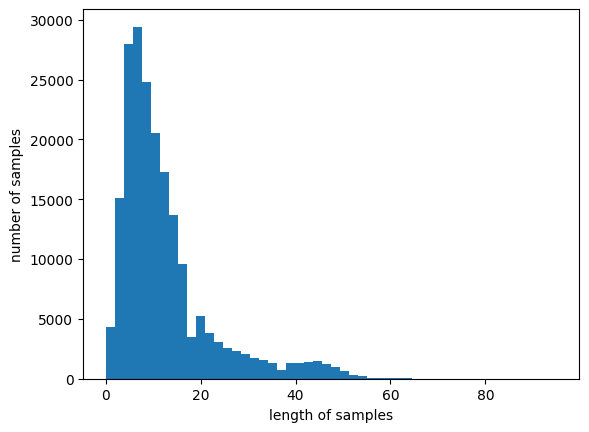

In [61]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Word2Vec으로 토큰화 된 네이버 영화 리뷰 데이터를 학습합니다.

In [64]:
from gensim.models import Word2Vec

In [65]:
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [66]:
print('완성된 임베딩 매트릭스의 크기 확인 :', model.wv.vectors.shape)

완성된 임베딩 매트릭스의 크기 확인 : (17615, 100)


학습이 다 되었다면 Word2Vec 임베딩 행렬의 크기를 확인합니다.

총 16,477개의 단어가 존재하며 각 단어는 100차원으로 구성되어져 있습니다. '최민식'과 유사한 단어들을 뽑아봅시다.

In [67]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8431532382965088), ('김명민', 0.8350170850753784), ('이정재', 0.8323151469230652), ('니콜슨', 0.8300267457962036), ('공리', 0.8283846378326416), ('박중훈', 0.821844756603241), ('최민수', 0.820631742477417), ('안성기', 0.8153480887413025), ('엄정화', 0.8089324831962585), ('설경구', 0.8075193762779236)]


'히어로'와 유사한 단어들을 뽑아봅시다.

In [68]:
print(model.wv.most_similar("히어로"))

[('슬래셔', 0.8763805031776428), ('무협', 0.863243818283081), ('SF', 0.8347493410110474), ('호러', 0.8237932324409485), ('sf', 0.8208317160606384), ('느와르', 0.8192753791809082), ('물의', 0.8122897148132324), ('홍콩', 0.7929659485816956), ('블랙', 0.7922343015670776), ('무비', 0.7878749370574951)]


In [69]:
print(model.wv.most_similar("발연기"))

[('연기', 0.7664225101470947), ('어색', 0.7471099495887756), ('연기력', 0.7448024749755859), ('조연', 0.7081387042999268), ('발음', 0.7046406269073486), ('사투리', 0.6948902606964111), ('미스캐스팅', 0.6639544367790222), ('케미', 0.6504823565483093), ('명연기', 0.6481116414070129), ('공효진', 0.6466346979141235)]


In [77]:
model.wv.index_to_key[:10]

['.', '영화', '보다', '..', '을', '...', ',', '없다', '이다', '있다']

In [81]:
model.wv.get_normed_vectors().shape

(17615, 100)

# 3. 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding) 소개
---
자연어 처리 작업을 할때, 케라스의 Embedding()를 사용하여 갖고 있는 훈련 데이터로부터 처음부터 임베딩 벡터를 훈련시키기도 하지만, 위키피디아 등의 방대한 데이터로 사전에 훈련된 워드 임베딩(pre-trained word embedding vector)를 가지고 와서 해당 벡터들의 값을 원하는 작업에 사용 할 수도 있습니다.

예를 들어서 감성 분류 작업을 하는데 훈련 데이터의 양이 부족한 상황이라면, 다른 방대한 데이터를 Word2Vec이나 GloVe 등으로 사전에 학습시켜놓은 임베딩 벡터들을 가지고 와서 모델의 입력으로 사용하는 것이 때로는 더 좋은 성능을 얻을 수 있습니다. 사전 훈련된 워드 임베딩을 가져와서 간단히 단어들의 유사도를 구해보는 실습을 해보겠습니다. 실제로 모델에 적용해보는 실습은 향후에 진행합니다.

구글이 제공하는 사전 훈련된(미리 학습되어져 있는) Word2Vec 모델을 사용하는 방법에 대해서 알아보겠습니다. 구글은 사전 훈련된 3백만 개의 Word2Vec 단어 벡터들을 제공합니다. 각 임베딩 벡터의 차원은 300입니다. gensim을 통해서 이 모델을 불러오는 건 매우 간단합니다. 이 모델을 다운로드하고 파일 경로를 기재하면 됩니다.

모델 다운로드 경로 : https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

압축 파일의 용량은 약 1.5GB이지만, 파일의 압축을 풀면 약 3.3GB의 파일이 나옵니다.

In [70]:
import gensim
import urllib.request

In [1]:
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

모델의 크기(shape)를 확인해봅시다.

In [ ]:
print(word2vec_model.vectors.shape)

(3000000, 300)


모델의 크기는 3,000,000 x 300입니다. 즉, 3백만 개의 단어와 각 단어의 차원은 300입니다. 파일의 크기가 3기가가 넘는 이유를 계산해보면 아래와 같습니다.

* 3 million words * 300 features * 4bytes/feature = ~3.35GB  

사전 훈련된 임베딩을 사용하여 두 단어의 유사도를 계산해봅시다.

In [ ]:
print(word2vec_model.similarity('this', 'is'))
print(word2vec_model.similarity('post', 'book'))

0.40797037
0.057204384


단어 'book'의 벡터를 출력해봅시다.

In [ ]:
print(word2vec_model['book'])

[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625  0.14355469 -0.140625   -0.03564453 -0.21289062
 -0.24804688  0.04980469 -0.09082031  0.14453125  0.05712891 -0.10400391
 -0.19628906 -0.20507812 -0.27539062  0.03063965  0.20117188  0.17382812
  0.09130859 -0.10107422  0.22851562 -0.04077148  0.02709961 -0.00106049
  0.02709961  0.34179688 -0.13183594 -0.078125    0.02197266 -0.18847656
 -0.17480469 -0.05566406 -0.20898438  0.04858398 -0.07617188 -0.15625
 -0.05419922  0.01672363 -0.02722168 -0.11132812 -0.03588867 -0.18359375
  0.28710938  0.01757812  0.02185059 -0.05664062 -0.01251221  0.01708984
 -0.21777344 -0.06787109  0.04711914 -0.00668335  0.08544922 -0.02209473
  0.31835938  0.01794434 -0.02246094 -0.03051758 -0.09570312  0.24414062
  0.20507812  0.05419922  0.29101562  0.03637695  0.04

참고 : Word2vec 모델은 자연어 처리에서 단어를 밀집 벡터로 만들어주는 단어 임베딩 방법론이지만 최근에 들어서는 자연어 처리를 넘어서 추천 시스템에도 사용되고 있는 모델입니다. 적당하게 데이터를 나열해주면 Word2vec은 위치가 근접한 데이터를 유사도가 높은 벡터를 만들어준다는 점에서 착안된 아이디어입니다. 관심있는 분들은 구글에 'item2vec'을 검색해보세요.